In [2]:
import sys
import os

import numpy as np
from torch.utils.data import DataLoader
import torch
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
from eofs.standard import Eof
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from py2d.derivative import derivative
from py2d.initialize import initialize_wavenumbers_rfft2, gridgen
from py2d.spectra import spectrum_zonal_average


# Get the current directory of your_script.py
current_dir = os.getcwd()
# Append the dataset directory to the Python path
dataset_path = os.path.join(current_dir, '..', 'dataset')
sys.path.append(dataset_path)
# Now import CustomMatDataset from dataloader.py
from dataloader import CustomMatDataset

dataType = 'Re5000_fkx4fky4_r0.1b0'
# train_data_dir = '../../py2d/examples/results/Re5000_fkx4fky4_r0.1_b20/NoSGS/NX32/dt0.0002_IC1/'
train_data_dir = '/home/exouser/Documents/karan/data/' + dataType  + '/NoSGS/NX256/dt0.0002_IC1/'
train_batch_size = 100
model_batch_size = 100
normalize = False # Saved samples are de-normalized
get_Omega = True
get_UV = True
downsample_procedure = 'physical'

file_range_test =[210000, 212500]



Downsample factor:  1


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/exouser/miniconda3/envs/diffusion/lib/python3.11/site-packages/scipy/io/matlab/_mio.py", line 39, in _open_file
    return open(file_like, mode), True
           ^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/exouser/Documents/karan/data/Re5000_fkx4fky4_r0.1b0/NoSGS/NX256/dt0.0002_IC1/data/212128.mat'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/exouser/miniconda3/envs/diffusion/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/exouser/miniconda3/envs/diffusion/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/exouser/miniconda3/envs/diffusion/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/exouser/Documents/karan/DDPM-Pytorch/tools/../dataset/dataloader.py", line 44, in __getitem__
    mat_data = scipy.io.loadmat(file_path)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/exouser/miniconda3/envs/diffusion/lib/python3.11/site-packages/scipy/io/matlab/_mio.py", line 225, in loadmat
    with _open_file_context(file_name, appendmat) as f:
  File "/home/exouser/miniconda3/envs/diffusion/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/exouser/miniconda3/envs/diffusion/lib/python3.11/site-packages/scipy/io/matlab/_mio.py", line 17, in _open_file_context
    f, opened = _open_file(file_like, appendmat, mode)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/exouser/miniconda3/envs/diffusion/lib/python3.11/site-packages/scipy/io/matlab/_mio.py", line 45, in _open_file
    return open(file_like, mode), True
           ^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/exouser/Documents/karan/data/Re5000_fkx4fky4_r0.1b0/NoSGS/NX256/dt0.0002_IC1/data/212128.mat'


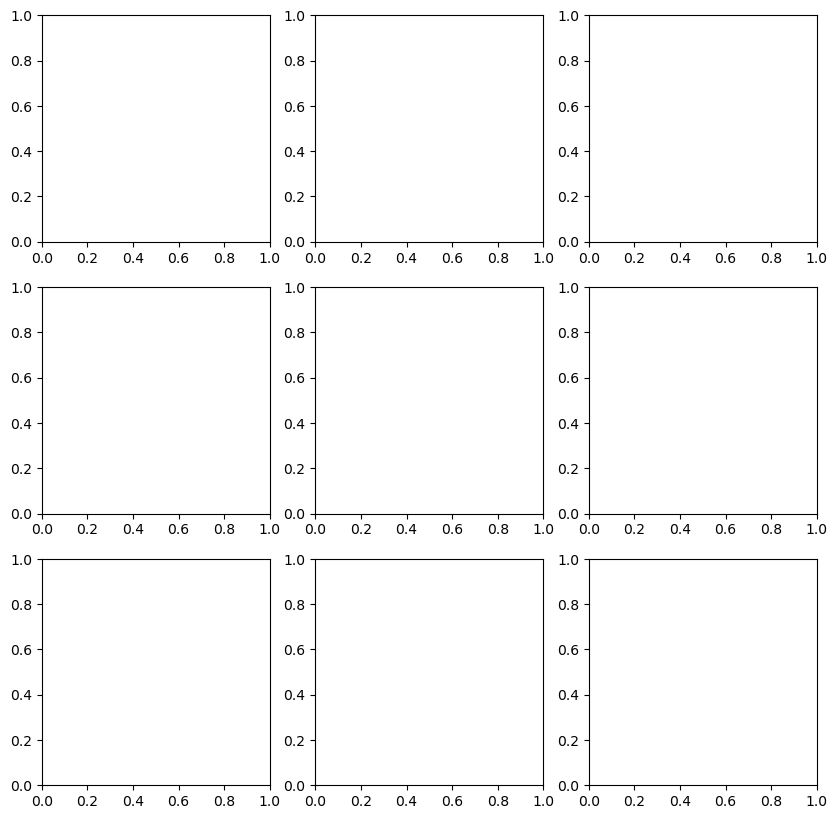

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

Lx, Ly = 2*np.pi, 2*np.pi # Domain size

markers = ['k', 'g', 'b', 'r']

for count, downsample_factor in enumerate([1,2,4,8]):
    print('Downsample factor: ', downsample_factor)

    dataset_train = CustomMatDataset(data_dir=train_data_dir, file_range=file_range_test, downsample_factor=downsample_factor, downsample_procedure=downsample_procedure, 
                                     get_UV=get_UV, get_Omega=get_Omega,normalize=normalize)
    turb_dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)

    iterator = iter(turb_dataloader_train)
    train_batch = next(iterator).numpy().astype(np.float32)
    # train_batch = next(iterator).numpy()

    spectra_U_arr = []
    spectra_V_arr = []
    spectra_Omega_arr = []

    zonal_U_arr = []
    zonal_V_arr = []
    zonal_Omega_arr = []

    div_arr = []
    Omega_diff_arr = []

    Nx = train_batch.shape[3]
    dx = Lx / Nx
    x = np.linspace(0, Lx - dx, num=Nx)
    Nx, Ny = train_batch.shape[3], train_batch.shape[2] # Number of grid points
    Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')
    Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(Nx, Ny, Lx, Ly, INDEXING='ij')

    for i in range(train_batch.shape[0]):
        data_U = train_batch[i, 0, :, :]
        data_V = train_batch[i, 1, :, :]
        data_Omega = train_batch[i, 2, :, :]

        Ux = derivative(data_U, [1, 0], Kx, Ky)
        Uy = derivative(data_U, [0, 1], Kx, Ky)
        Vx = derivative(data_V, [1, 0], Kx, Ky)
        Vy = derivative(data_V, [0, 1], Kx, Ky)

        # div = np.mean(Ux + Vy)
        div = np.mean(np.abs(Ux + Vy))
        div_arr.append(div)

        # Omega_diff = np.mean(data_Omega - (Vy - Ux))
        Omega_diff = np.mean(np.abs((data_Omega - (Vx - Uy))))
        Omega_diff_arr.append(Omega_diff)

        spectra_U_temp, wavenumber = spectrum_zonal_average(data_U)
        spectra_V_temp, wavenumber = spectrum_zonal_average(data_V)
        spectra_Omega_temp, wavenumber = spectrum_zonal_average(data_Omega)

        spectra_U_arr.append(spectra_U_temp)
        spectra_V_arr.append(spectra_V_temp)
        spectra_Omega_arr.append(spectra_Omega_temp)

        zonal_U_temp = np.mean(data_U, axis=0)
        zonal_V_temp = np.mean(data_V, axis=0)
        zonal_Omega_temp = np.mean(data_Omega, axis=0)

        zonal_U_arr.append(zonal_U_temp)
        zonal_V_arr.append(zonal_V_temp)
        zonal_Omega_arr.append(zonal_Omega_temp)

    spectra_U = np.mean(spectra_U_arr, axis=0)
    spectra_V = np.mean(spectra_V_arr, axis=0)
    spectra_Omega = np.mean(spectra_Omega_arr, axis=0)

    zonal_U = np.mean(zonal_U_arr, axis=0)
    zonal_V = np.mean(zonal_V_arr, axis=0)
    zonal_Omega = np.mean(zonal_Omega_arr, axis=0)

    if downsample_factor == 1:
        label = '$N_{DNS}$ = ' + str(Nx)
    else:
        label = '$N_{coarse}$ = ' + str(Nx)


    axes[0, 0].loglog(wavenumber[:-1], spectra_U[:-1], markers[count], label=label)
    axes[0, 1].loglog(wavenumber[:-1], spectra_V[:-1], markers[count], label=label)
    axes[0, 2].loglog(wavenumber[:-1], spectra_Omega[:-1], markers[count], label=label)

    # axes[0, 0].loglog(wavenumber, spectra_U, markers[count], label=label)
    # axes[0, 1].loglog(wavenumber, spectra_V, markers[count], label=label)
    # axes[0, 2].loglog(wavenumber, spectra_Omega, markers[count], label=label)

    axes[1, 0].plot(zonal_U, x, markers[count], label=label)
    axes[1, 2].plot(zonal_Omega, x, markers[count], label=label)

    axes[2, 0].semilogy(div_arr, markers[count], label=label)
    axes[2, 1].semilogy(Omega_diff_arr, markers[count], label=label)

axes[0,0].set_ylim([1e-4, 1e1])
axes[0,1].set_ylim([1e-4, 1e1])
axes[0,2].set_ylim([1e-4, 1e1])
axes[2,0].set_ylim([1e-6, 1e0])

axes[0, 0].set_title('U Spectra')
axes[0, 1].set_title('V Spectra')
axes[0, 2].set_title('Omega Spectra')
axes[1, 0].set_title('U Zonal')
axes[1, 2].set_title('$\omega$ Zonal')
axes[2, 0].set_title('Divergence')
axes[2, 1].set_title('$\omega$ Diff')

axes[2,0].set_xlabel('# Snapshots')
axes[2,0].set_ylabel('<abs(div)>')

# axes[0,0].legend(loc='lower left', frameon=False)
axes[2,0].legend(frameon=False)

Downsample factor:  1


Downsample factor:  2
Downsample factor:  4


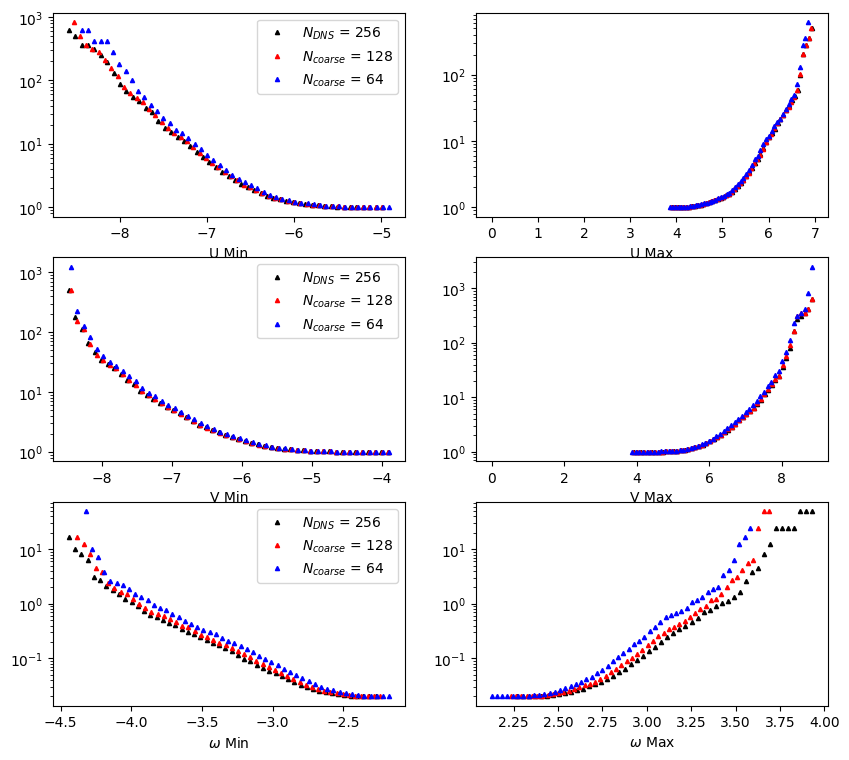

In [4]:
def return_period(data, dt=1, bins=50, bin_range=None):
    '''
    Return period for a time series data
    Inverse of the exceedance probability
    '''
    # Compute histogram frequencies and bin edges
    freq, bin_edges = np.histogram(data, bins=bins, range=bin_range)
    # Compute bin centers
    bins_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    # Compute cumulative frequencies from the highest bin downwards
    freq_exceedance = np.cumsum(freq[::-1])[::-1]
    # Total number of data points
    total_data_points = len(data)
    # Calculate exceedance probabilities
    prob_exceedance = freq_exceedance / total_data_points
    # Avoid division by zero in return period calculation
    prob_exceedance = np.clip(prob_exceedance, 1e-14, 1)
    # Calculate return periods
    return_periods = dt / prob_exceedance
    return return_periods, prob_exceedance, bins_centers


file_range_test =[110000, 112500]
markersize = 3

fig, axes = plt.subplots(3, 2, figsize=(10, 9))

Lx, Ly = 2*np.pi, 2*np.pi # Domain size

markers_dict = {}
markers_dict['spectral'] = ['ok', 'or', 'ob', 'or']
markers_dict['physical'] = ['^k', '^r', '^b', '^r']

for count_down, downsample_factor in enumerate([1, 2, 4]):
    print('Downsample factor: ', downsample_factor)

    # for downsample_procedure in ['spectral', 'physical']:
    for downsample_procedure in ['physical']:

        dataset_train = CustomMatDataset(data_dir=train_data_dir, file_range=file_range_test, downsample_factor=downsample_factor, downsample_procedure=downsample_procedure,
                                        get_UV=get_UV, get_Omega=get_Omega,normalize=normalize)
        turb_dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
        train_batch = next(iter(turb_dataloader_train)).numpy().astype(np.float32)

        Nx, Ny = train_batch.shape[3], train_batch.shape[2] # Number of grid points
        Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')
        Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(Nx, Ny, Lx, Ly, INDEXING='ij')

        U_max_arr, V_max_arr, Omega_max_arr, Omega_from_UV_max_arr = [], [], [], []
        U_min_arr, V_min_arr, Omega_min_arr, Omega_from_UV_min_arr = [], [], [], []

        for count, batch in enumerate(turb_dataloader_train):
            train_batch = batch.numpy()

            for i in range(train_batch.shape[0]):
                data_U = train_batch[i, 0, :, :]
                data_V = train_batch[i, 1, :, :]
                data_Omega = train_batch[i, 2, :, :]

                Uy = derivative(data_U, [0, 1], Kx, Ky)
                Vx = derivative(data_V, [1, 0], Kx, Ky)

                Omega_from_UV = Vx - Uy

                U_max_arr.append(np.max(data_U))
                V_max_arr.append(np.max(data_V))
                Omega_max_arr.append(np.max(data_Omega))
                Omega_from_UV_max_arr.append(np.max(Omega_from_UV))

                U_min_arr.append(np.min(data_U))
                V_min_arr.append(np.min(data_V))
                Omega_min_arr.append(np.min(data_Omega))
                Omega_from_UV_min_arr.append(np.min(Omega_from_UV))

        return_U_max, freq_U_max, bins_U_max = return_period(U_max_arr, bins=50)
        return_V_max, freq_V_max, bins_V_max = return_period(V_max_arr, bins=50)
        return_Omega_max, freq_Omega_max, bins_Omega_max = return_period(Omega_max_arr, bins=50)
        return_Omega_from_UV_max, freq_Omega_from_UV_max, bins_Omega_from_UV_max = return_period(Omega_max_arr, bins=50)

        return_U_min, freq_U_min, bins_U_min = return_period(np.abs(U_min_arr), bins=50)
        return_V_min, freq_V_min, bins_V_min = return_period(np.abs(V_min_arr), bins=50)
        return_Omega_min, freq_Omega_min, bins_Omega_min = return_period(np.abs(Omega_min_arr), bins=50)
        return_Omega_from_UV_min, freq_Omega_from_UV_min, bins_Omega_from_UV_min = return_period(np.abs(Omega_from_UV_min_arr), bins=50)

        if downsample_factor == 1:
            label = '$N_{DNS}$ = ' + str(Nx)
        else:
            label = '$N_{coarse}$ = ' + str(Nx)

        markers = markers_dict[downsample_procedure]

        axes[0, 0].semilogy(-bins_U_min, return_U_min, markers[count_down], markersize=markersize, label=label)
        axes[0, 1].semilogy(bins_U_max, return_U_max, markers[count_down], 'o', markersize=markersize, label=label)
        
        axes[1, 0].semilogy(-bins_V_min, return_V_min,  markers[count_down], markersize=markersize, label=label)
        axes[1, 1].semilogy(bins_V_max, return_V_max, markers[count_down], 'o', markersize=markersize, label=label)
        
        axes[2, 0].semilogy(-bins_Omega_min/10.5, np.asarray(return_Omega_min)*0.02,  markers[count_down], markersize=markersize, label=label)
        # axes[2, 0].semilogy(-bins_Omega_from_UV_min, return_Omega_from_UV_min, markers[count_down], markersize=markersize, label=' (Omega from UV): ' + str(downsample_factor))
        axes[2, 1].semilogy(bins_Omega_max/10.5, np.asarray(return_Omega_max)*0.02,  markers[count_down], markersize=markersize, label=label)
        # axes[2, 1].semilogy(bins_Omega_from_UV_max, return_Omega_from_UV_max, markers[count_down], markersize=markersize, label='(Omega from UV): ' + str(downsample_factor))

axes[0, 1].set_xlabel('U Max')
axes[0, 0].set_xlabel('U Min')
axes[1, 1].set_xlabel('V Max')
axes[1, 0].set_xlabel('V Min')
axes[2, 1].set_xlabel('$\omega$ Max')
axes[2, 0].set_xlabel('$\omega$ Min')

axes[0,0].legend()
axes[1,0].legend()
axes[2,0].legend()